## Importación de librerías y lectura de datos

In [3]:
from pandas_profiling import ProfileReport

# Pandas
import pandas as pd
pd.set_option('display.max_columns', 25) # Número máximo de columnas a mostrar
pd.set_option('display.max_rows', 50) # Numero máximo de filas a mostar

# Numpy
import numpy as np
np.random.seed(3301)

# Seaborn
import seaborn as sns 

# Matplolib
%matplotlib inline
import matplotlib.pyplot as plt

# librería Natural Language Toolkit, usada para trabajar con texts
import unicodedata
import string
from nltk.stem import LancasterStemmer, WordNetLemmatizer
import re
from nltk.corpus import stopwords
from nltk import word_tokenize, sent_tokenize
import inflect
import contractions
import nltk
# Punkt permite separar un text en frases.
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [4]:
db_route = '../data/SuicidiosProyecto.csv'
df_originales = pd.read_csv(db_route, encoding = 'ISO-8859-1')

# Imprimir número de filas
print('Número de filas: ', df_originales.shape[0])
# Imprimir número de columnas
print('Número de columnas: ', df_originales.shape[1])

pd.set_option('display.max_columns', None)
df_originales.sample(5)

Número de filas:  195700
Número de columnas:  3


,Unnamed: 0,text,class
21738,135566,AAAA I'm literally the stupidest person in exi...,non-suicide
26627,17383,Is it just me or is the sound of rain One of t...,non-suicide
135198,36707,"How close i amam tired of living, tired of bei...",suicide
140848,186151,Guess who kissed a girl? Not me.\n\n&amp;#x200...,non-suicide
79670,255320,Should I delete my Reddit account? I mean shou...,non-suicide


<AxesSubplot:title={'center':'class'}>

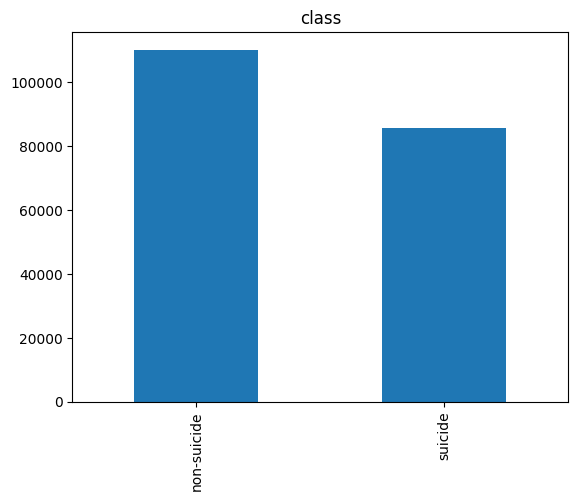

In [5]:
# Visualizar en gráfica de barras cantidad de valores por valor en la columna 'class'
df_originales['class'].value_counts().plot(kind='bar', title='class')

Para las primeras pruebas por temas de tiempos de ejecución, se utilizan solo 5000 registros aleatorios. Estos 5000 registros, se seleccionan balanceados entre registros clasificados como suicidio y registros que no. Ya cuando se tenga el modelo probado, se utilizarán todos los datos.

In [6]:
# # Keep only 5000 random rows balanced between the two values of the column 'class' 
# df_originales = df_originales.groupby('class', group_keys=False).apply(lambda x: x.sample(min(len(x), 2500)))
# # df_originales = df_originales.sample(n=5000)

# # Imprimir número de filas
# print('Número de filas: ', df_originales.shape[0])
# # Imprimir número de columnas
# print('Número de columnas: ', df_originales.shape[1])


## Limpieza y entendimiento de datos

In [7]:
# Ver datos núlos
print("\nNúmero de filas con valores nulos: ", df_originales.isnull().any(axis=1).sum())
print("Número de columnas con valores nulos: ", df_originales.isnull().any().sum())

# Porcentaje de completitud
print(f"\nPorcentaje de completitud de las columnas: {(1-(df_originales.isnull().any(axis=1).sum()/df_originales.shape[0]))*100:.2f}%")


Número de filas con valores nulos:  0
Número de columnas con valores nulos:  0

Porcentaje de completitud de las columnas: 100.00%


In [8]:
# Ver duplicidad de datos
print("\nNúmero de filas duplicadas: ", df_originales.duplicated().sum())
print("Número de filas con indice duplicado: ", df_originales['Unnamed: 0'].duplicated().sum())


Número de filas duplicadas:  0
Número de filas con indice duplicado:  0


In [9]:
# Eliminar columna 'Unnamed: 0'
df_originales.drop('Unnamed: 0', axis=1, inplace=True)
# Convertir valores de la columna text a string
df_originales['text'] = df_originales['text'].astype(str)

In [10]:
# Obtener valores únicos columna 'class' 
print(df_originales['class'].value_counts())

# En la columna 'class' cambiar valores 'non-suicide' por 0 y 'suicide' por 1
df_originales['class'] = df_originales['class'].replace({'non-suicide': 0, 'suicide':1})

# Obtener valores únicos columna 'class' 
print(df_originales['class'].value_counts())

# Convertir la columna en numerica
df_originales['class'] = df_originales['class'].astype(int)

non-suicide    110165
suicide         85535
Name: class, dtype: int64
0    110165
1     85535
Name: class, dtype: int64


## Procesamiento de texto

Por facilidad y tiempos de respuesta, se hace un preprocesamiento antes de separar los datos en tokens: se eliminan caracteres especiales, puntuación y números, y se convierte el texto a minúscula. Para el caso de suicidios no se considera que los números sean importantes.

In [11]:
# Eliminar caracteres distintos al alfabeto en la columna 'text'
df_originales['text'] = df_originales['text'].str.replace('[^a-zA-Z ]', '')

# Convertir columna text a minúsculas
df_originales['text'] = df_originales['text'].str.lower()

C:\Users\User\AppData\Local\Temp\ipykernel_1380\903552774.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df_originales['text'] = df_originales['text'].str.replace('[^a-zA-Z ]', '')


Métodos para preprocesamiento de texto:

In [12]:
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode(
            'ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words


def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def replace_numbers(words):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords.words('english'):
            new_words.append(word)
    return new_words

def remove_words_without_vowels(words):
    """Remove words without vowels from list of tokenized words"""
    new_words = []
    for word in words:
        if re.search('[aeiouy]', word):
            new_words.append(word)
    return new_words

def preprocessing(words):
    # words = to_lowercase(words)
    # words = replace_numbers(words)
    # words = remove_punctuation(words)
    # words = remove_non_ascii(words)
    words = remove_words_without_vowels(words)
    words = remove_stopwords(words)
    return words

In [13]:
df_modelo = df_originales.copy()
df_modelo['text'] = df_modelo['text'].apply(contractions.fix)

In [14]:
df_modelo['tokens'] = df_modelo['text'].apply(word_tokenize).apply(preprocessing) 

# Eliminar tokens vacíos y con longitud menor a 2
df_modelo['tokens'] = df_modelo['tokens'].apply(lambda x: [item for item in x if item != '' and (len(item) >= 2 or item == 'i')])

Métodos lematización y eliminación de prefijos y sufijos (stemming) [NORMALIZACIÓN]:

In [15]:
def stem_words(words):
    # Stem: cortar la raíz de una palabra
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def stem_and_lemmatize(words):
    stems = stem_words(words)
    lemmas = lemmatize_verbs(words)
    return stems + lemmas

In [16]:
# Aplica lematización y Eliminación de Prefijos y Sufijos.
df_modelo['tokens'] = df_modelo['tokens'].apply(stem_and_lemmatize)

df_modelo.sample(5)

,text,class,tokens
60891,going to buy my first console ps what are some...,0,"[going, buy, first, consol, gam, must, play, m..."
78088,make it stop pleasei cannot do this anymore i ...,1,"[mak, stop, please, anym, much, pain, everyday..."
169268,i just wanted to share one of the embarrassing...,0,"[want, shar, on, embarrassingawkward, tim, lif..."
159499,can i roast your country if willing to take so...,0,"[roast, country, wil, tak, crit, pleas, nam, c..."
82956,when the imposter when the impogster sus jdksj...,0,"[impost, impogst, sus, jdksjdjdhekehdidkdjj, s..."


In [17]:
df_modelo['tokens'] = df_modelo['tokens'].apply(
    lambda x: ' '.join(map(str, x)))

In [18]:
# Eliminación de columna 'text' para disminuir el tamaño del dataset
df_modelo.drop('text', axis=1, inplace=True)

# Eliminar filas con valores nulos
df_modelo.dropna(inplace=True)

## Vectorización de texto

La vectorización de datos se va a realizar en los archivos específicos de cada modelo utilizando la librería sklearn.feature_extraction.text.TfidfVectorizer.

## Exportación de datos procesados

In [19]:
from pathlib import Path

try:
    filepath = Path('../data/processed_data.csv')
    # filepath = Path('../data/processed_data_min.csv')
    df_modelo.to_csv(filepath, index=False)
    print("Archivo guardado exitosamente")
except Exception as e:
    print("Error al guardar el archivo: " + str(e))

Archivo guardado exitosamente
